<a href="https://colab.research.google.com/github/mslarson94/NMA2022_ECoG/blob/experimental/projects/ECoG/TA_spectogram_load_ECoG_memory_nback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Miller ECoG data of the memory nback task

includes some visualizations

In [ ]:
# @title Data retrieval
import os, requests

fname = 'memory_nback.npz'
url = "https://osf.io/xfc7e/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`, `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 9.6 MB 4.4 MB/s 
     |████████████████████████████████| 13.3 MB 3.8 MB/s 
     |████████████████████████████████| 3.2 MB 35.5 MB/s 
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 179 kB 30.7 MB/s 


In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[1][1]

print(dat.keys())

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [ ]:
dat.keys()

dict_keys(['V', 't_off', 'locs', 'srate', 'scale_uv', 't_on', 'target', 'stim_id', 'response', 'rt', 'expinfo', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])

In [ ]:
type(dat['V'])
n_time, n_chan=np.shape(dat['V'])




---
# Dataset info

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 3 sessions from 3 subjects, and was not yet used in a publication, so it's fresh data for you to analyze! The following references using other datasets may be useful for the memory n-back task: 

- Brouwer, Anne-Marie, et al. "Estimating workload using EEG spectral power and ERPs in the n-back task." Journal of Neural Engineering 9.4 (2012): 045008. doi: [10.1088/1741-2560/9/4/045008](https://doi.org/10.1088/1741-2560/9/4/045008)

- Grissmann, Sebastian, et al. "Electroencephalography based analysis of working memory load and affective valence in an n-back task with emotional stimuli." Frontiers in Human Neuroscience 11 (2017): 616. doi: [10.3389/fnhum.2017.00616](https://doi.org/10.3389/fnhum.2017.00616)

Each subject's data is divided into 5 sessions: fixation, exp1, exp2, exp3, fixation, which are consecutive blocks in the data structure (i.e. `alldat[0][0]`, `alldat[0][1]`, ..., `alldat[0][4]` for subject 0). Exp1 is a "0-back" memory experiment, where the subjects have to identify the picture of one of the houses (stimid = 10), which they have memorized at the beginning of the stimulus block. Exp2 is a 1-back memory experiment, where the participants have to respond to images of repeated houses. Finally, exp3 is 2-back where participants respond to pictures of houses that are repeated after another intervening random picture. This task was hard for these participants and most of them did not really respond at all, but the data can still be used to ask questions about overall shifts of neural activity in a hard task when the subjects feel overwhelmed by the memory requirements.

Note that for the third/last subject, no response data was collected, so only the first two subjects can be analyzed for their correct / incorrect trials.   

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size. 

Variables for each block within each subject: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['expinfo']`: experiment type for this block
* `dat['srate']`: sampling rate for voltage data, always 1000Hz
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, usually 600 samples after `t_on`
* `dat['stim_id`]: identity of house stimulus from 1 to 40. Stimulus 10 was the target in the 0-back task.  
* `dat['target']`: 0 or 1, indicates if this stimulus requires a response
* `dat['response']`: 0 or 1, indicates if the subject actually made a response
* `dat['rt']`: reaction time for trials with a response in voltage data samples (1000Hz). 
* `dat['locs']`: 3D locations of the electrodes on the cortical surface

In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 576x576 with 0 Axes>

In [ ]:

def get_voltage_patient_expirement_data(data, patient, experiment,freq_range):
    # compute spectral power above 50Hz and low-pass below 10Hz
  # power is always positive, so we normalize it by its average
  from scipy import signal
  dat=data[patient][experiment]
  V = dat['V'].astype('float32') # always convert the voltage data to float32!

  # # high-pass filter above 50 Hz
  b, a = signal.butter(3, [freq_range[0],freq_range[1]], btype='bandpass', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  # b, a = signal.butter(3, [freq_range[0]], btype='low', fs=1000)
  # V = signal.filtfilt(b, a, V, 0)


  # # compute smooth envelope of this signal = approx power
  # V = np.abs(V)**2
  # b, a = signal.butter(3, [freq_range[0]], btype='low', fs=1000)
  # V = signal.filtfilt(b, a, V, 0)

  # # normalize each channel so its mean power is 1
  #V = V/V.mean(0)
  return V, dat




#should I get voltage 

In [ ]:
stim_10_loc=[]
for i in range(len(dat['stim_id'])):
  if dat['stim_id'][i]==10:
    stim_10_loc.append(i)
  

In [ ]:
stim_10_loc

[47, 48, 97, 98]

In [ ]:

gamma_range=[70,150]
V, dat=get_voltage_patient_expirement_data(alldat,0,2,[1,150])


In [ ]:
V


array([[ -747.21333797,   546.6228734 , -1855.95324967, ...,
          657.92946373, -2627.85357721, -4873.60579141],
       [ -791.55538456,   533.67222958, -1904.01879707, ...,
          768.67536863, -2602.1770421 , -4892.48628804],
       [ -813.33018566,   555.87685155, -1906.41225054, ...,
          830.48111392, -2606.32459211, -4939.29309952],
       ...,
       [ -373.91896174,  -867.30614101,   -59.44754097, ...,
         -861.43530621,  -846.33795869, -1319.55182828],
       [ -244.56246605,  -697.74841997,   127.05541428, ...,
         -997.04580902,  -945.79962757, -1421.0373106 ],
       [ -258.05849624,  -752.57103107,     5.49808276, ...,
         -830.24740819,  -823.85232797, -1173.44247146]])

In [ ]:
import scipy.signal as ssig

# divide into trials and average
nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-500, 1700)
ts = dat['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2200, nchan))

V_onrp = (V_epochs[dat['target']==1]).mean(0)
V_ofrp = (V_epochs[dat['target']==0]).mean(0)
V_resp = (V_epochs[dat['response'] == 1]).mean(0)
V_base = (V_epochs[dat['response'] == 0]).mean(0)

V_epochs_averaged=np.mean(V_epochs,0)

In [ ]:
np.shape(V)

(240080, 64)

In [ ]:
print(stim_10_loc)
dat['rt'][stim_10_loc]

dat['response'][98] == 1

[47, 48, 97, 98]


True

In [ ]:
V_base=np.mean(V[:6000],1)

In [ ]:
stim_10_loc[1::2]

[48, 98]

In [ ]:
t

array([0.05 , 0.138, 0.226, 0.314, 0.402, 0.49 , 0.578, 0.666, 0.754,
       0.842, 0.93 , 1.018, 1.106, 1.194, 1.282, 1.37 , 1.458, 1.546,
       1.634, 1.722, 1.81 , 1.898, 1.986, 2.074])

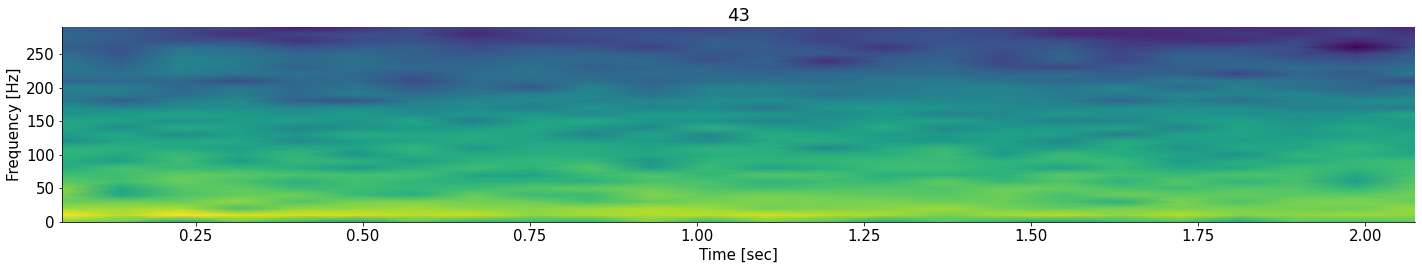

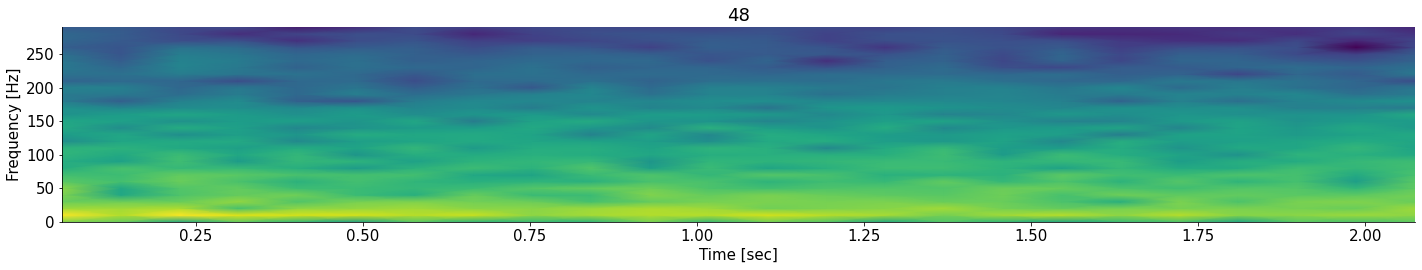

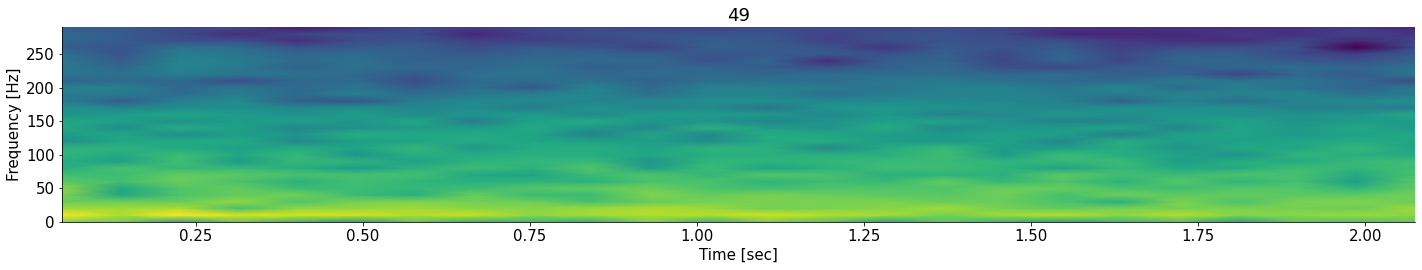

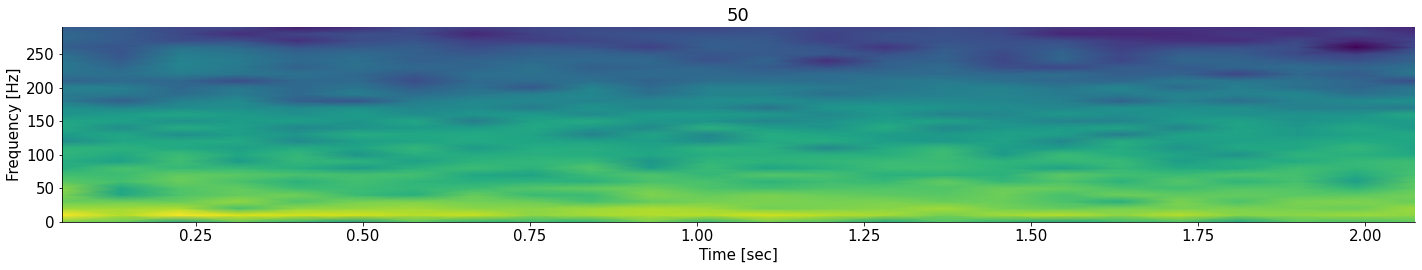

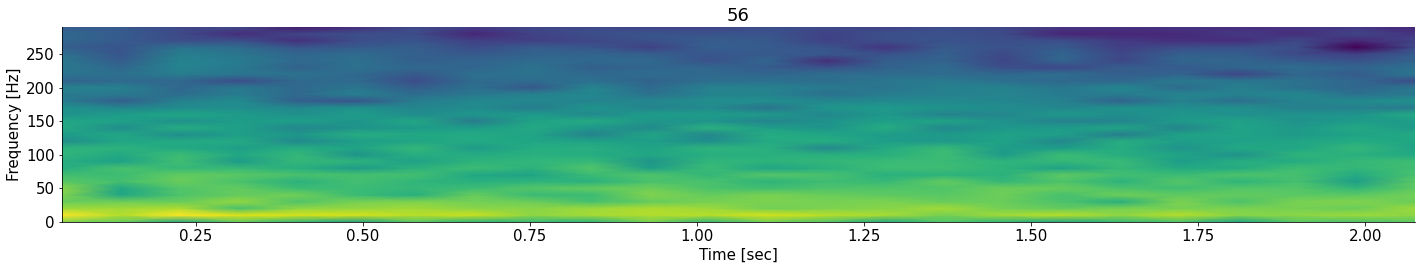

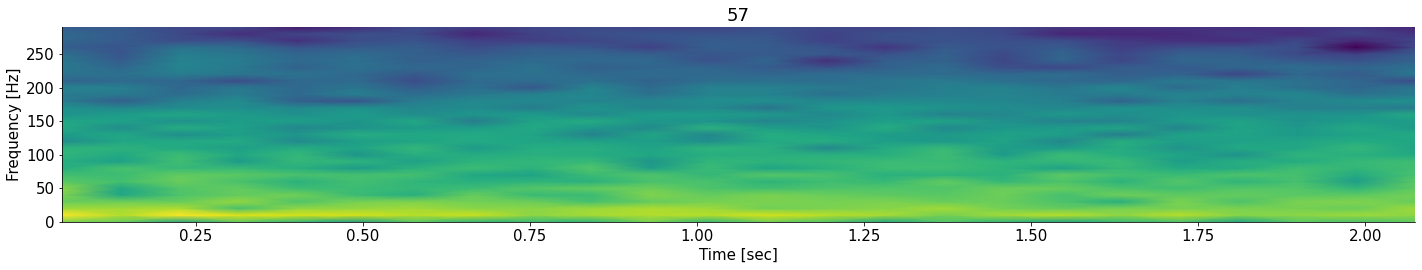

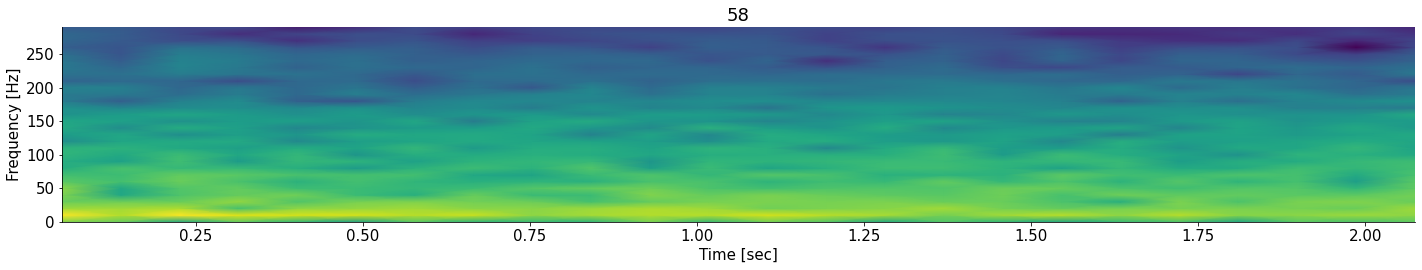

In [ ]:
import scipy
# for i in [20, 28, 36, 37, 44, 45, 51, 52, 53, 59, 60, 61]:
for i in [43, 48, 49, 50, 56, 57, 58]:
  # for j in stim_10_loc:
  chan=i
  f,t, Sxx2=scipy.signal.spectrogram(np.mean(V_epochs[stim_10_loc[::2],:,i],0),1000,window=('tukey',.25),nperseg=100)
  plt.pcolormesh(t, f[:30], np.log(Sxx[:30,:]), shading='gouraud')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.title(chan)
  plt.show()

In [ ]:
np.max(Sxx)

0.17606769752355542

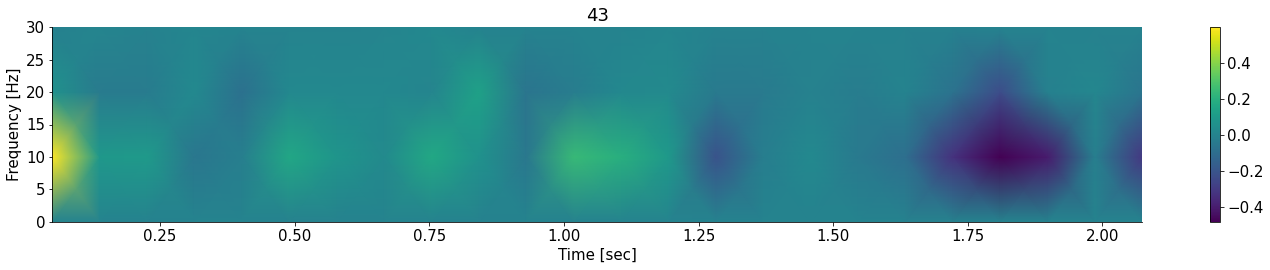

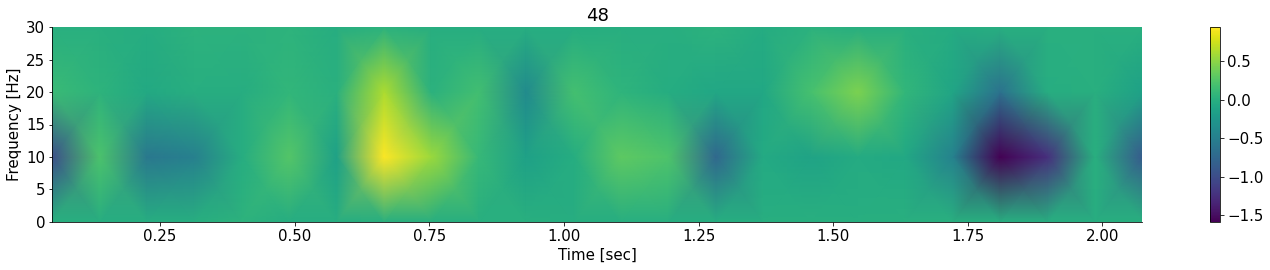

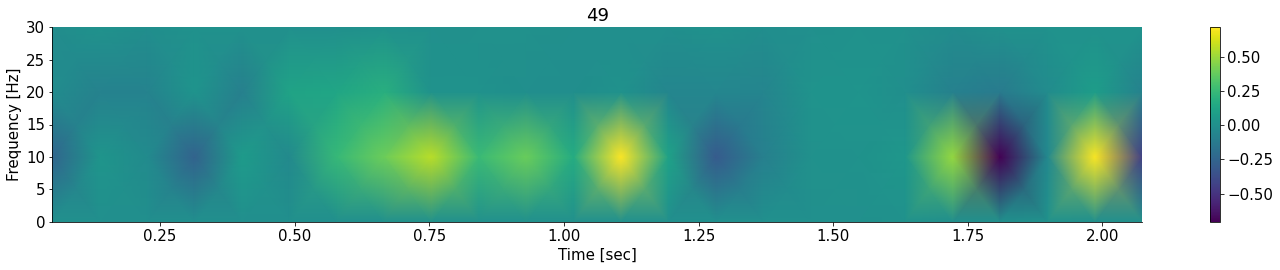

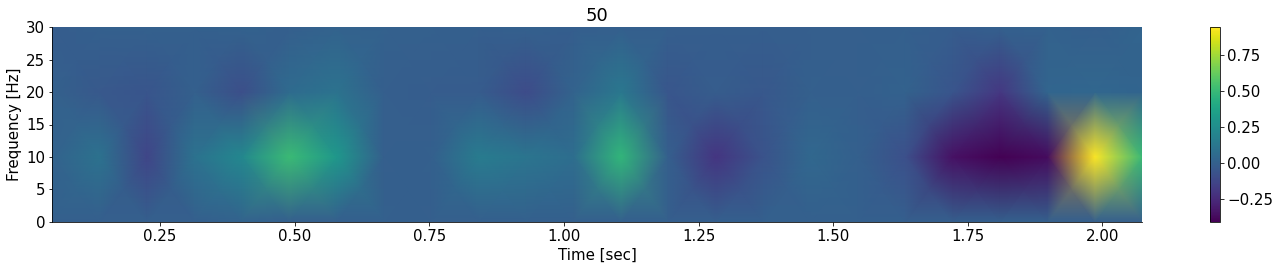

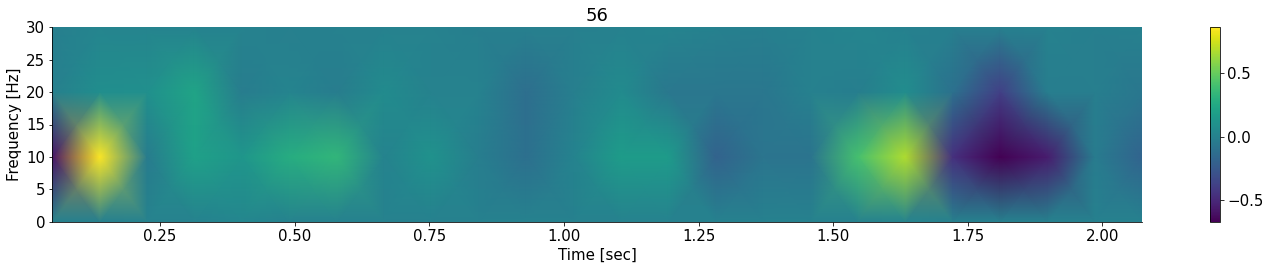

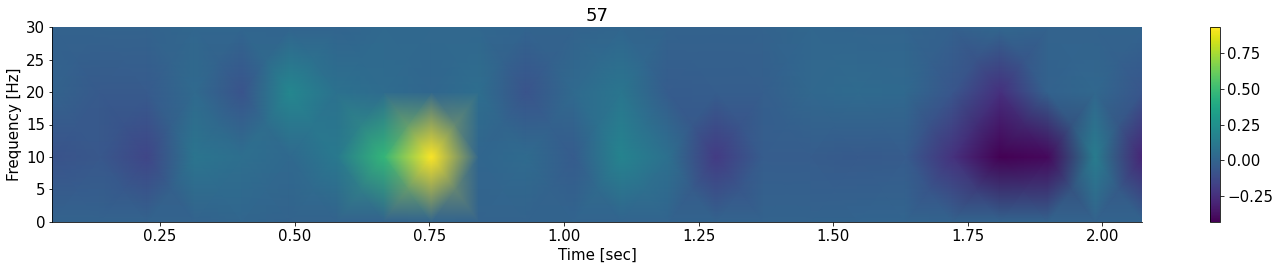

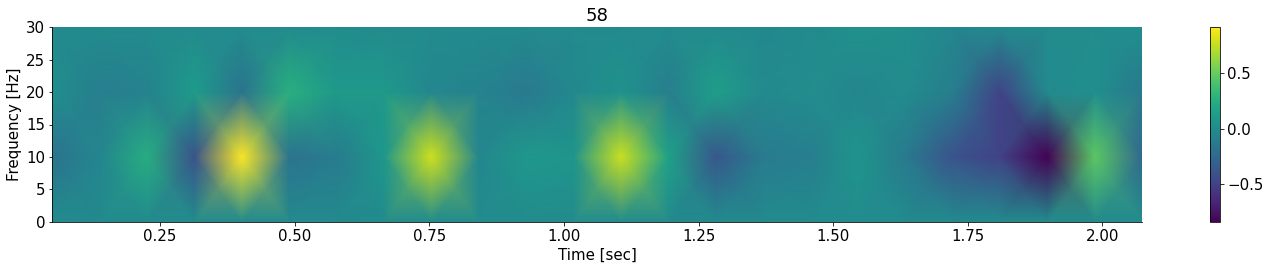

In [ ]:
import scipy
# for i in [20, 28, 36, 37, 44, 45, 51, 52, 53, 59, 60, 61]:
for i in [43, 48, 49, 50, 56, 57, 58]:
  # for j in stim_10_loc:
  chan=i
  f,t, Sxx=scipy.signal.spectrogram(np.mean(V_epochs[stim_10_loc[1::2],:,i],0),1000,window=('tukey',.25),nperseg=100)
  fig, ax0 = plt.subplots(nrows=1)
  im=ax0.pcolormesh(t, f[:4], (Sxx[:4,:]-Sxx2[:4,:])/np.max(Sxx), shading='gouraud')
  fig.colorbar(im, ax=ax0)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.title(chan)
  plt.show()

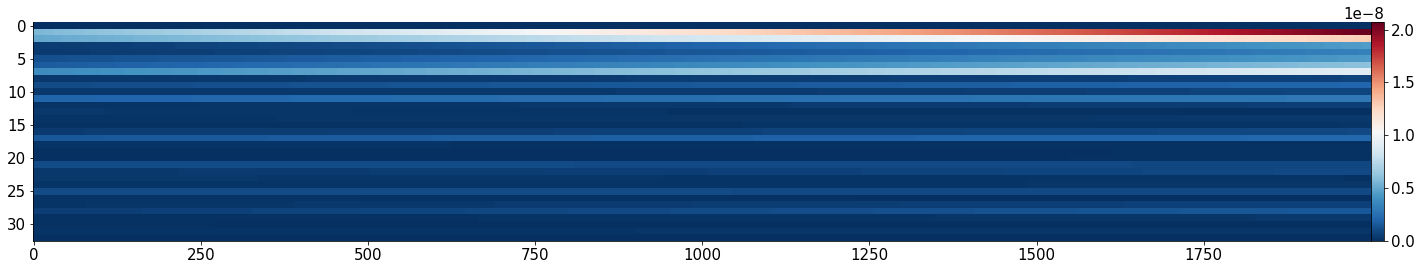

In [ ]:
fig, ax=plt.subplots()
im=ax.imshow(sxx[:,:,0].T, aspect='auto', cmap='RdBu_r', rasterized=True, interpolation='none')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right",size="1%", pad=0)
clb=fig.colorbar(im,cax=cax)

In [ ]:
sxx.shape

(2000, 33, 1)

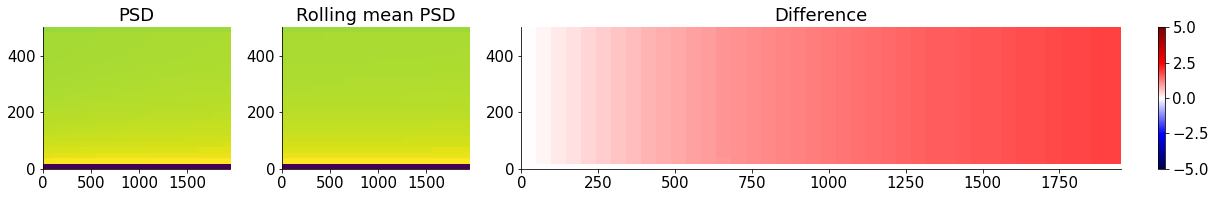

In [ ]:
scipy.signal.spectrogram()
V_epochs_averaged.shape
sr=1000
chunktime=50 #time in ms
chunk=int((chunktime *sr)/1000)
nchunks=int(np.floor(V_epochs_averaged.shape[0]/chunk))

chan=V_epochs_averaged[:,0]
nc = nchunks
minpower = 1e-30
psdmat = np.empty((chan.shape[0], chunk//2 + 1, nc))
rolling_psdmat = np.empty_like(psdmat)
alpha = 1 - 1e-2
for c in range(nc):
    slc = slice(c * chunk, (c + 1) * chunk)
    dat2 = chan[ slc]
    freqs, this_psd = ssig.periodogram(dat2, fs=sr)
    this_psd = np.maximum(minpower, this_psd)
    psdmat[:, :, c] = this_psd
    if c == 0:
        rolling_psd = this_psd
    else:
        rolling_psd = alpha * rolling_psd + (1 - alpha) * this_psd
    rolling_psdmat[:, :, c] = rolling_psd


fig, ax = plt.subplots(1, 3, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 1, 4]})
ax[0].imshow(10 * np.log10(psdmat[0]), aspect='auto', origin='lower', extent=(0, (nc - 1) * chunktime, freqs[0], freqs[-1]))
ax[0].set_title('PSD')
ax[1].imshow(10 * np.log10(rolling_psdmat[0]), aspect='auto', origin='lower', extent=(0, (nc - 1) * chunktime, freqs[0], freqs[-1]))
ax[1].set_title('Rolling mean PSD')
im = ax[2].imshow(10 * (np.log10(psdmat[0]) - np.log10(rolling_psdmat[0])),
                  aspect='auto', origin='lower', extent=(0, (nc - 1) * chunktime, freqs[0], freqs[-1]),
                 vmin=-5, vmax=5, cmap='seismic')
ax[2].set_title('Difference')
plt.colorbar(im)

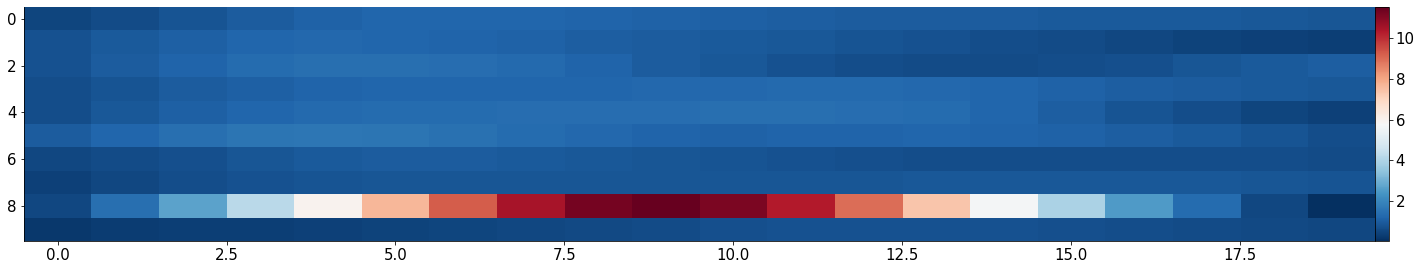

In [ ]:
fig, ax=plt.subplots()
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
im=ax.imshow(V[1900:1920,30:40].T, aspect='auto', cmap='RdBu_r', rasterized=True, interpolation='none')
divider=make_axes_locatable(ax)
cax=divider.append_axes("right",size="1%", pad=0)
clb=fig.colorbar(im,cax=cax)

In [ ]:
def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()

  

In [ ]:
# divide into trials and average
nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-400, 1600)
ts = dat['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_onrp = (V_epochs[dat['target']==1]).mean(0)
V_ofrp = (V_epochs[dat['target']==0]).mean(0)
V_resp = (V_epochs[dat['response'] == 1]).mean(0)
V_base = (V_epochs[dat['response'] == 0]).mean(0)

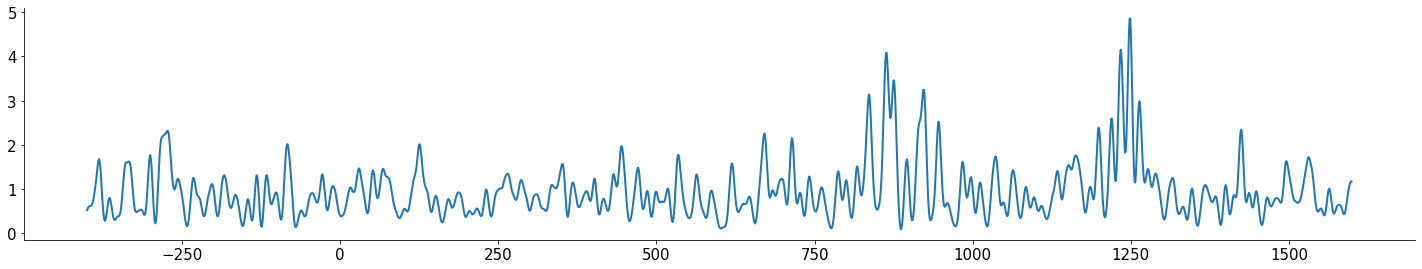

In [ ]:
plt.plot(trange, V_epochs[dat['response'] == 1][16,:,19], lw=2)


In [ ]:
dat['rt']

array([ nan,  nan,  nan, 846.,  nan,  nan,  nan, 623., 578.,  nan,  nan,
        nan,  nan,  nan,  nan, 500.,  nan, 520.,  nan,  nan,  nan, 486.,
        nan,  nan,  nan,  nan,  nan, 475.,  nan,  nan,  nan, 578.,  nan,
       421., 508.,  nan,  nan,  nan,  nan,  nan,  nan, 610.,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 659.,  nan,
        nan,  nan, 605., 514.,  nan,  nan,  nan,  nan,  nan,  nan, 578.,
        nan, 502.,  nan,  nan,  nan, 520.,  nan,  nan,  nan,  nan,  nan,
       658.,  nan,  nan,  nan, 458.,  nan, 493., 431.,  nan,  nan,  nan,
        nan,  nan, 675., 463.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan])

In [ ]:
dat['t_on']

array([  6681,   8881,  11081,  13281,  15481,  17681,  19881,  22081,
        24281,  26481,  28681,  30881,  33081,  35281,  37481,  39681,
        41881,  44081,  46281,  48481,  50681,  52881,  55081,  57281,
        59481,  61681,  63881,  66081,  68281,  70481,  72681,  74881,
        77081,  79281,  81481,  83681,  85881,  88081,  90281,  92481,
        94681,  96881,  99081, 101281, 103481, 105681, 107881, 110081,
       112281, 114481, 126761, 128961, 131161, 133361, 135561, 137761,
       139961, 142161, 144361, 146561, 148761, 150961, 153161, 155361,
       157561, 159761, 161961, 164161, 166361, 168561, 170761, 172961,
       175161, 177361, 179561, 181761, 183961, 186161, 188361, 190561,
       192761, 194961, 197161, 199361, 201561, 203761, 205961, 208161,
       210361, 212561, 214761, 216961, 219161, 221361, 223561, 225761,
       227961, 230161, 232361, 234561])

In [ ]:
dat['target']

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [ ]:
dat['stim_id']


array([39, 19,  7,  7,  6,  6, 20, 28, 12, 27, 29, 14, 11, 40,  2,  2,  1,
        1, 26,  3,  3,  4,  4, 37, 30, 22, 36, 35,  8,  8, 34, 32,  5,  5,
       15, 17, 25, 24, 33, 21, 31,  9,  9, 18, 13, 23, 38, 10, 10, 16, 39,
       19,  7,  7,  6,  6, 20, 28, 12, 27, 29, 14, 11, 40,  2,  2,  1,  1,
       26,  3,  3,  4,  4, 37, 30, 22, 36, 35,  8,  8, 34, 32,  5,  5, 15,
       17, 25, 24, 33, 21, 31,  9,  9, 18, 13, 23, 38, 10, 10, 16],
      dtype=uint8)

In [ ]:
print(dat['Brodmann_Area'][19]) #~ Primary_somatasensory_cortex
print(dat['Brodmann_Area'][28])
print(dat['Brodmann_Area'][21])
print(dat['Brodmann_Area'][37])


Brodmann area 44
Brodmann area 6
Brodmann area 43
Brodmann area 6


In [ ]:
print(dat['lobe'][51]) #~ Primary_somatasensory_cortex
print(dat['lobe'][28])
print(dat['lobe'][21])
print(dat['lobe'][37])

Frontal Lobe
Frontal Lobe
Parietal Lobe
Frontal Lobe


In [ ]:
print(dat['gyrus'][51])
print(dat['gyrus'][28])
print(dat['gyrus'][21])
print(dat['gyrus'][37])


Middle Frontal Gyrus
Precentral Gyrus
Postcentral Gyrus
Precentral Gyrus


List of things to automate for easier use:
  Automate different bands of activity? 
  Automate different patients 
  Automate where different lobes of stuff can do

In [ ]:
gamma_range=[70,150]

patient_list=[0,1,2]



In [ ]:
# let's find the electrodes that distinguish responses from non-responses
# note these are event-related potentials

plt.figure(figsize=(15, 12))
for j in range(60):
  ax = plt.subplot(6, 10, j+1)
  plt.plot(trange, V_onrp[:, j], lw=2)
  plt.plot(trange, V_ofrp[:, j], lw=2)
  plt.title('ch%d'%j)
  plt.yticks([])
  plt.ylim([0, 3])
plt.show()

TypeError: ignored

<Figure size 1080x864 with 0 Axes>

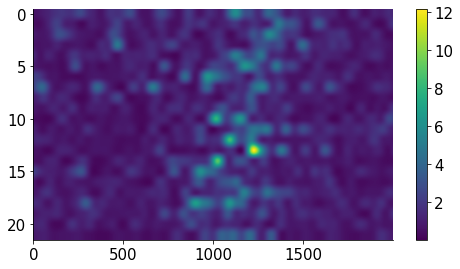

In [ ]:
# let's look at all the response trials for the electrode that has a significant response
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[dat['response']==1, :, 21].astype('float32'),
           aspect='auto')
plt.colorbar()
plt.show()

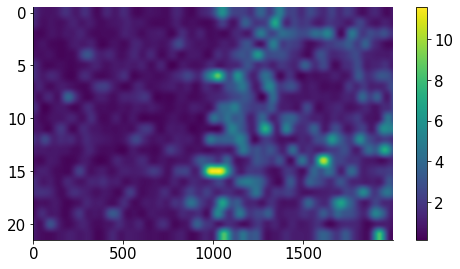

In [ ]:
# this electrode has a more transient response
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[dat['response']==1, :, 27].astype('float32'),
           aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
# to do: do these responses covary with the reaction times? are they present on trials where there is no motor response?

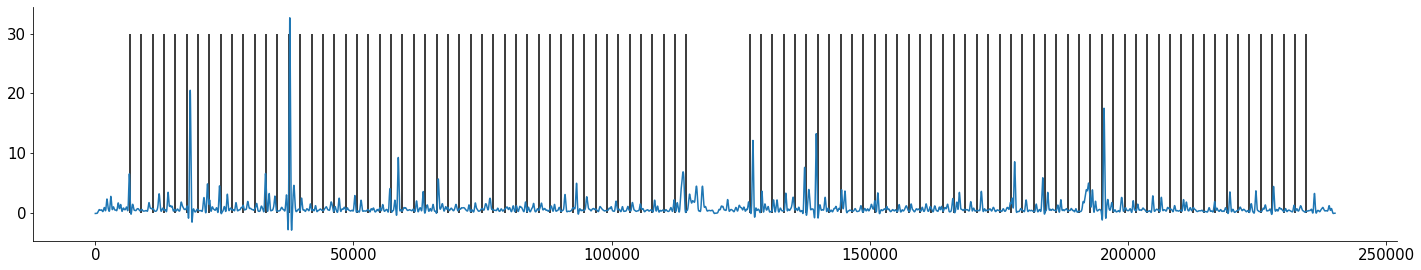

In [ ]:

alpha_range=[2,50]
V, dat=get_voltage_patient_expirement_data(alldat,0,1,alpha_range)


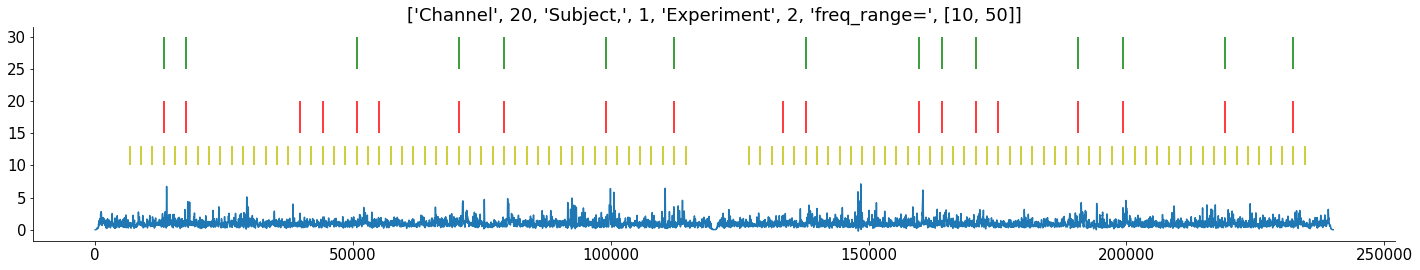

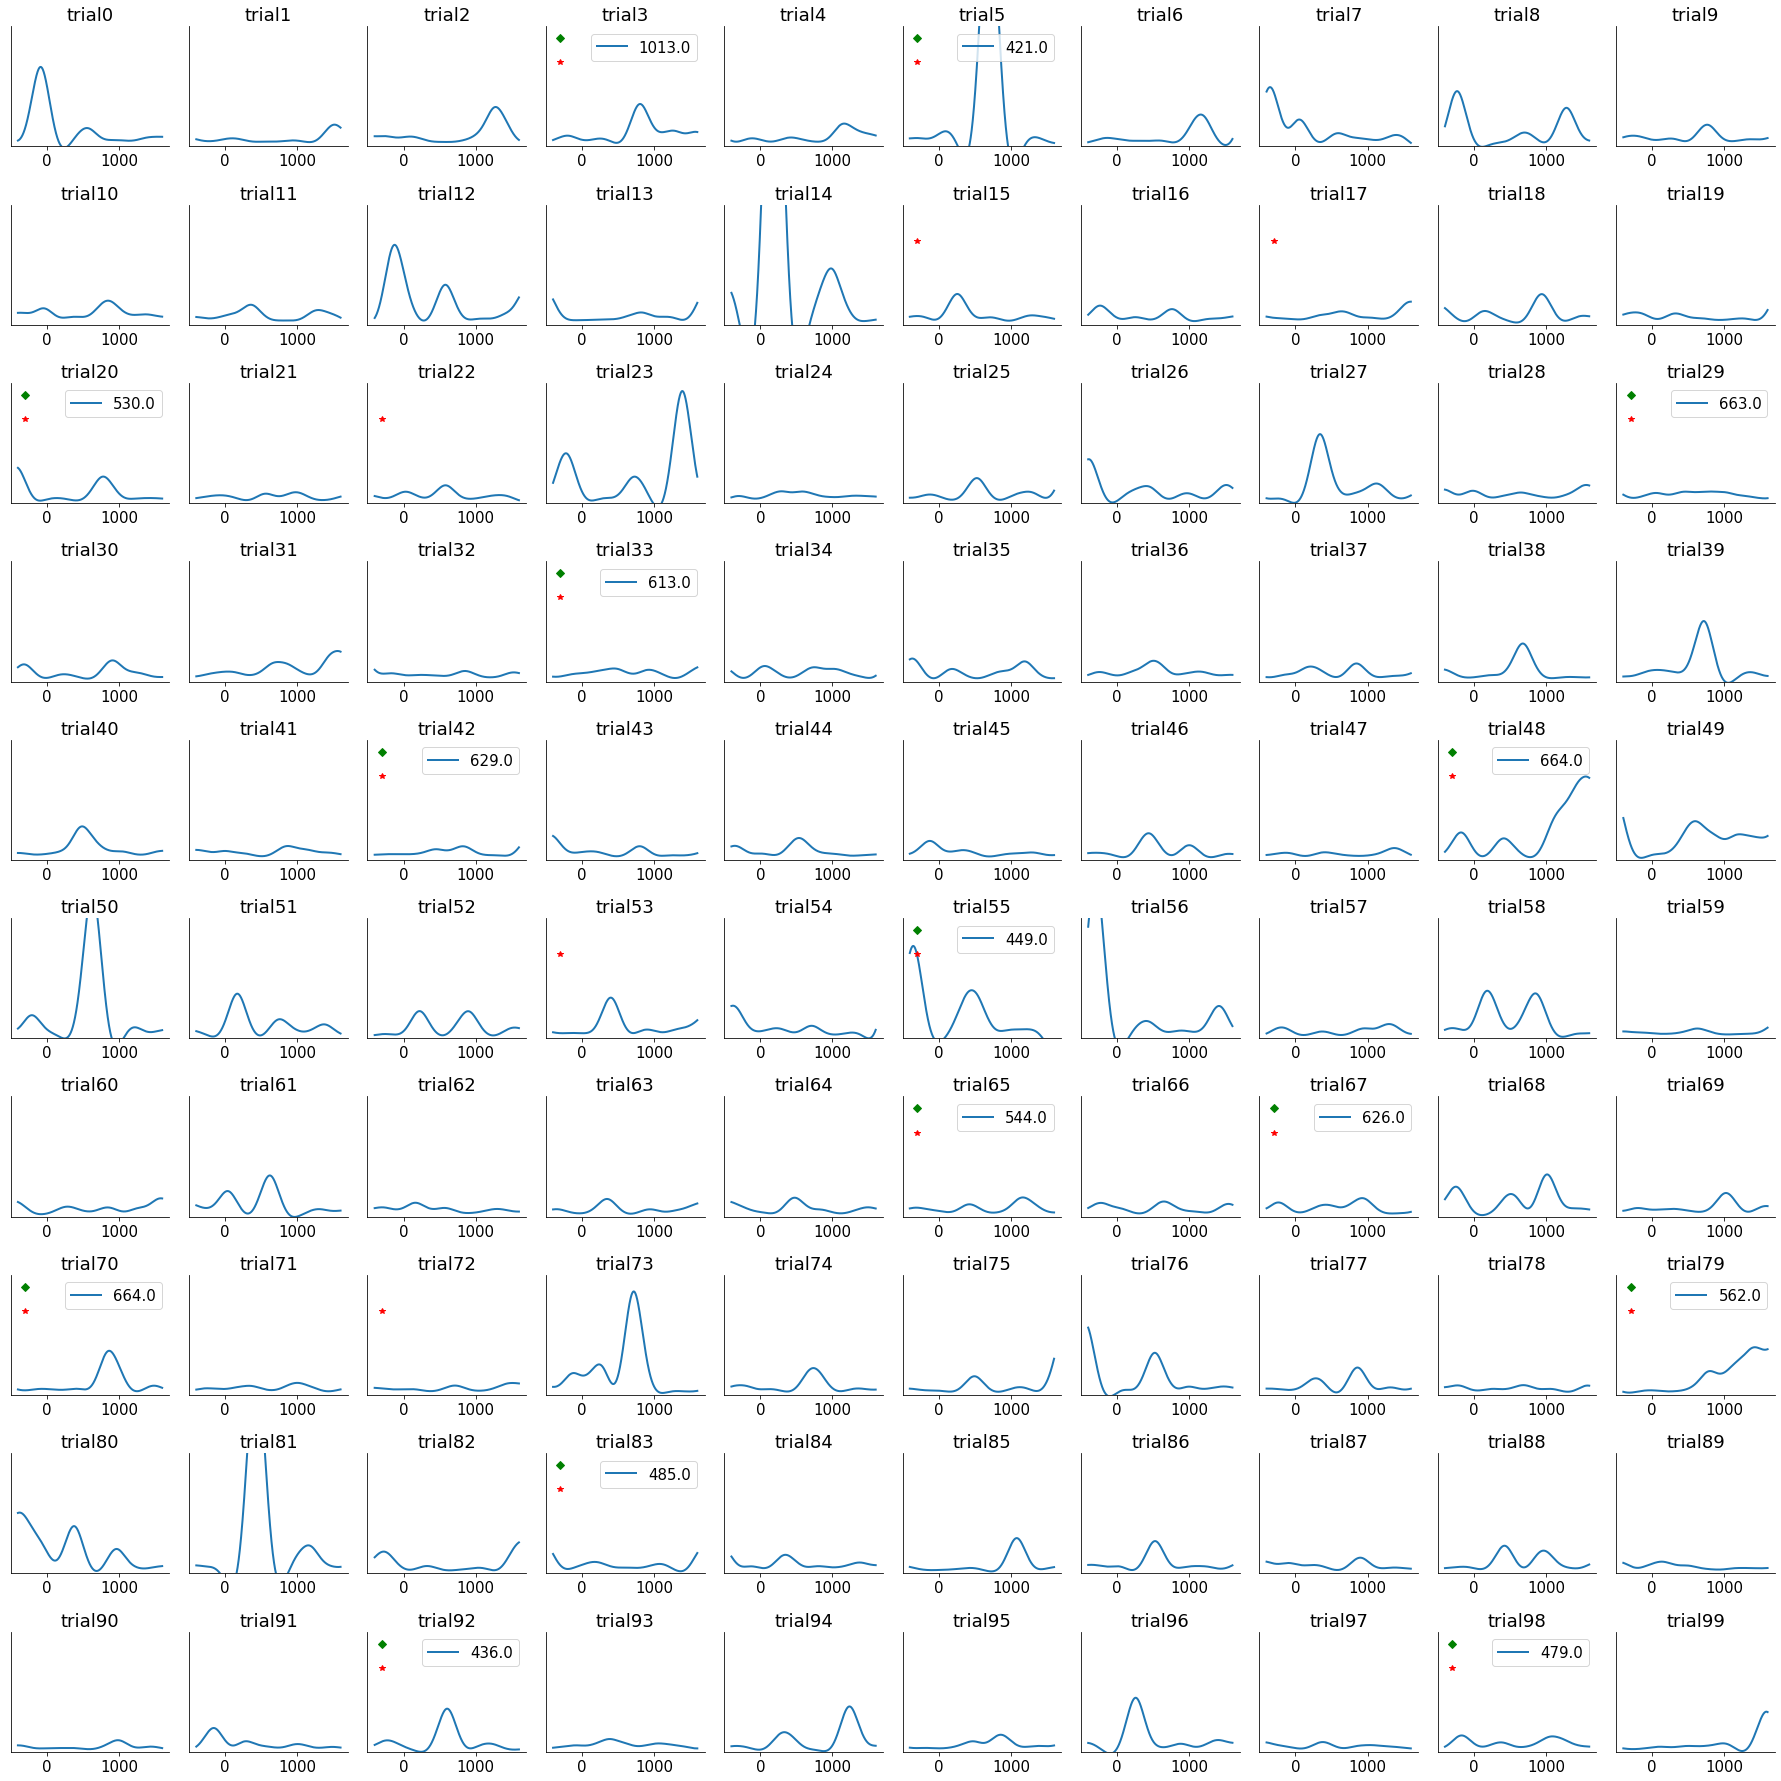

In [ ]:





from matplotlib.markers import MarkerStyle
chan=20
subject_number=1
experiment_number=2
f_range=[10,50]
V, dat=get_voltage_patient_expirement_data(alldat,subject_number,experiment_number,f_range)


plt.plot(V[:,chan])
plt.vlines(dat['t_on'],10, 13,colors='y')
plt.vlines(dat['t_on'][np.argwhere(dat['target']==1)],15,20,colors='r')
plt.vlines(dat['t_on'][np.argwhere(dat['response']==1)],25,30,colors='g')
plt.title(['Channel', chan, 'Subject,', subject_number,'Experiment', experiment_number, 'freq_range=', f_range])

plt.figure(figsize=(25, 25))
for j in range(100):
  ax = plt.subplot(10, 10, j+1)

  plt.plot(trange, V_epochs[j,: ,chan], lw=2)
  #plt.plot(trange, V_ofrp[j,:,chan], lw=2)
  if np.any(np.argwhere(dat['target']==1)==j):
    plt.plot(-300,7,'r',marker='*')
  if np.any(np.argwhere(dat['response']==1)==j):
    plt.plot(-300,9,'g',marker='D')
    plt.legend([dat['rt'][j]], loc='upper right',  title_fontsize='xx-small')

  plt.title('trial%d'%j)
  plt.yticks([])
  plt.ylim([0,10])
plt.show()

In [ ]:
del(range)

In [ ]:
# divide into trials and average
nt, nchan = V.shape
nstim = len(dat['t_on'])

# use a timerange from 400ms before to 1600ms after the stimulus onset
trange = np.arange(-400, 1600)
ts = dat['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

In [ ]:
dat['rt'][3]

1013.0

In [ ]:
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_onrp = (V_epochs[dat['target']==1])
V_ofrp = (V_epochs[dat['target']==0])
V_resp = (V_epochs[dat['response'] == 1])
V_base = (V_epochs[dat['response'] == 0])

In [ ]:
dat['target']

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
dat['t_on']*dat['target']
dat['t_on']*dat['response']

array([     0,      0,      0,  13281,      0,      0,      0,  22081,
        24281,      0,      0,      0,      0,      0,      0,  39681,
            0,  44081,      0,      0,      0,  52881,      0,      0,
            0,      0,      0,  66081,      0,      0,      0,  74881,
            0,  79281,  81481,      0,      0,      0,      0,      0,
            0,  96881,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0, 133321,      0,      0,
            0, 142121, 144321,      0,      0,      0,      0,      0,
            0, 159721,      0, 164121,      0,      0,      0, 172921,
            0,      0,      0,      0,      0, 186121,      0,      0,
            0, 194921,      0, 199321, 201521,      0,      0,      0,
            0,      0,      0, 216921,      0,      0,      0,      0,
            0,      0,      0,      0])

In [ ]:
np.any(np.argwhere(dat['target']==1)==2)

False

In [ ]:
dat['t_on'][np.argwhere(dat['target']==1)]

array([[ 13281],
       [ 22081],
       [ 24281],
       [ 39681],
       [ 44081],
       [ 52881],
       [ 66081],
       [ 74881],
       [ 79281],
       [ 81481],
       [ 96881],
       [133321],
       [142121],
       [144321],
       [159721],
       [164121],
       [172921],
       [186121],
       [194921],
       [199321],
       [201521],
       [216921]])